#Library

In [4]:
#Pip Install
#!pip install --upgrade statsmodels
#!pip install prophet

In [5]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from prophet import Prophet
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler


# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

#Pre Processing Data

In [6]:
df_train = pd.read_csv('store5.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [8]:
# Check for missing values
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

In [9]:
# hapus kolom id dan store_nbr
df_train.drop(['id', 'store_nbr'], axis=1, inplace=True)
# Mengubah tipe data kolom date menjadi datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Mengurutkan data berdasarkan tanggal
df_train = df_train.set_index('date')
df_train

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.000,0,NaN
2013-01-01,BABY CARE,0.000,0,NaN
2013-01-01,BEAUTY,0.000,0,NaN
2013-01-01,BEVERAGES,0.000,0,NaN
2013-01-01,BOOKS,0.000,0,NaN
...,...,...,...,...
2017-08-15,POULTRY,241.011,1,47.57
2017-08-15,PREPARED FOODS,52.121,0,47.57
2017-08-15,PRODUCE,1357.823,4,47.57


In [10]:
# Check  value
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

In [11]:
# Total penjualan per family dengan format yang mudah dilihat
pd.options.display.float_format = '{:,.0f}'.format

df_train.groupby('family')['sales'].sum().sort_values(ascending=False)

family
GROCERY I                    5,262,682
BEVERAGES                    2,533,831
CLEANING                     1,667,748
PRODUCE                      1,653,582
DAIRY                          871,283
BREAD/BAKERY                   642,855
MEATS                          477,104
PERSONAL CARE                  450,166
POULTRY                        419,630
DELI                           415,271
FROZEN FOODS                   269,669
HOME CARE                      239,283
EGGS                           190,851
PREPARED FOODS                 147,991
LIQUOR,WINE,BEER               110,414
HOME AND KITCHEN II             37,238
GROCERY II                      33,241
LINGERIE                        31,561
HOME AND KITCHEN I              30,107
CELEBRATION                     26,176
SEAFOOD                         22,359
LADIESWEAR                      14,813
AUTOMOTIVE                       9,194
BEAUTY                           8,684
PLAYERS AND ELECTRONICS          8,024
MAGAZINES         

In [12]:
# Total penjualan per family dengan format yang mudah dilihat
pd.options.display.float_format = '{:,.0f}'.format

df_train.groupby('family')['onpromotion'].sum().sort_values(ascending=False)

family
GROCERY I                     37323
PRODUCE                       24483
BEVERAGES                     18413
CLEANING                      12786
DELI                          12448
DAIRY                         10580
MEATS                          6669
PERSONAL CARE                  4547
EGGS                           4440
POULTRY                        4199
BREAD/BAKERY                   3347
HOME CARE                      3335
FROZEN FOODS                   1953
LIQUOR,WINE,BEER               1041
HOME AND KITCHEN I              924
SEAFOOD                         881
HOME AND KITCHEN II             690
PREPARED FOODS                  416
BEAUTY                          261
CELEBRATION                     206
LAWN AND GARDEN                 157
SCHOOL AND OFFICE SUPPLIES       77
GROCERY II                       60
LINGERIE                         57
PET SUPPLIES                     42
AUTOMOTIVE                       19
PLAYERS AND ELECTRONICS           9
LADIESWEAR           

#Visualisasi data

In [13]:
# Ambil data penjualan untuk family meats
meats = df_train['family']=='MEATS'
meats = df_train[meats]
meats

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,MEATS,0,0,NaN
2013-01-02,MEATS,455,0,93
2013-01-03,MEATS,353,0,93
2013-01-04,MEATS,407,0,93
2013-01-05,MEATS,467,0,NaN
...,...,...,...,...
2017-08-11,MEATS,327,34,49
2017-08-12,MEATS,235,0,NaN
2017-08-13,MEATS,242,0,NaN


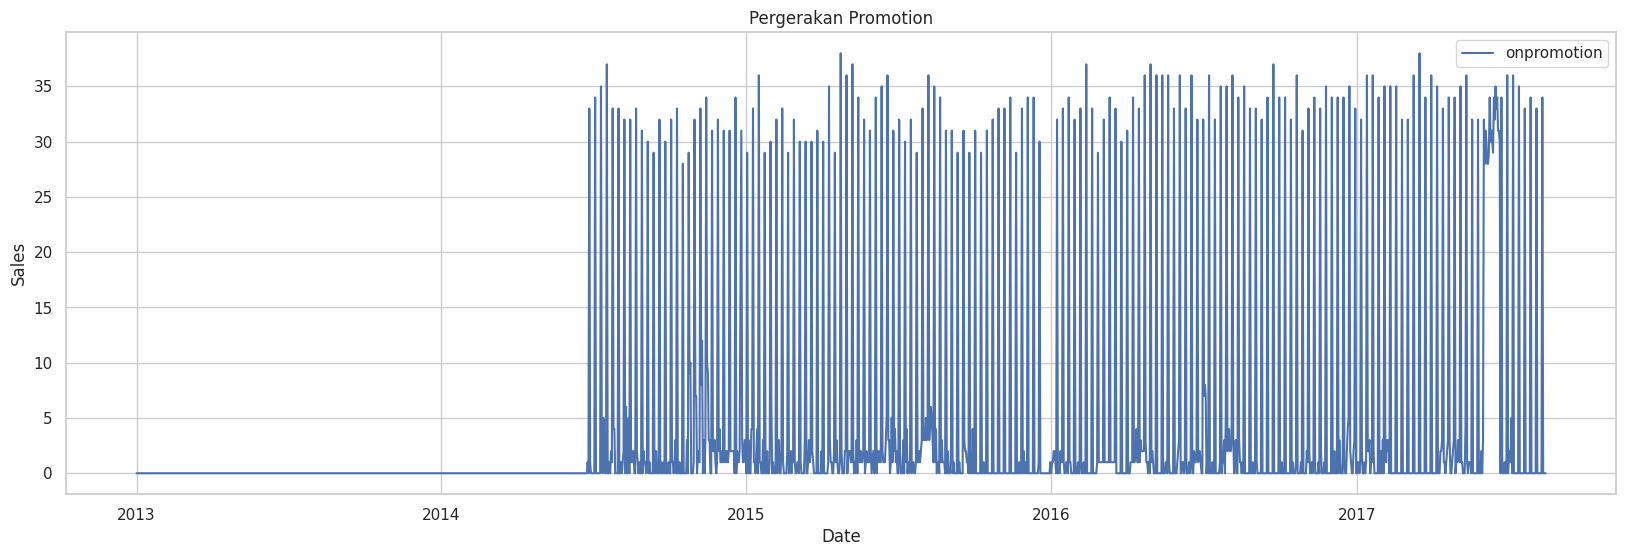

In [14]:
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

sns.lineplot(data=meats, x='date', y='onpromotion', label='onpromotion')
plt.title('Pergerakan Promotion')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

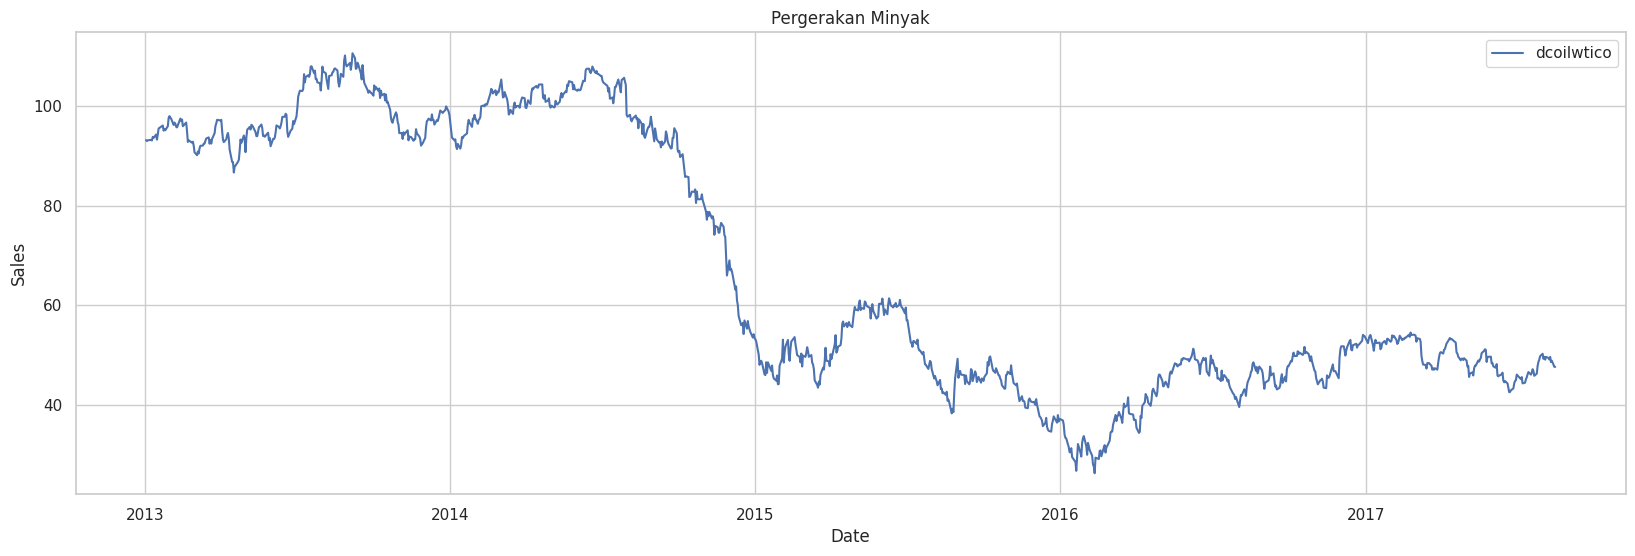

In [15]:
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

sns.lineplot(data=meats, x='date', y='dcoilwtico', label='dcoilwtico')
plt.title('Pergerakan Minyak')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

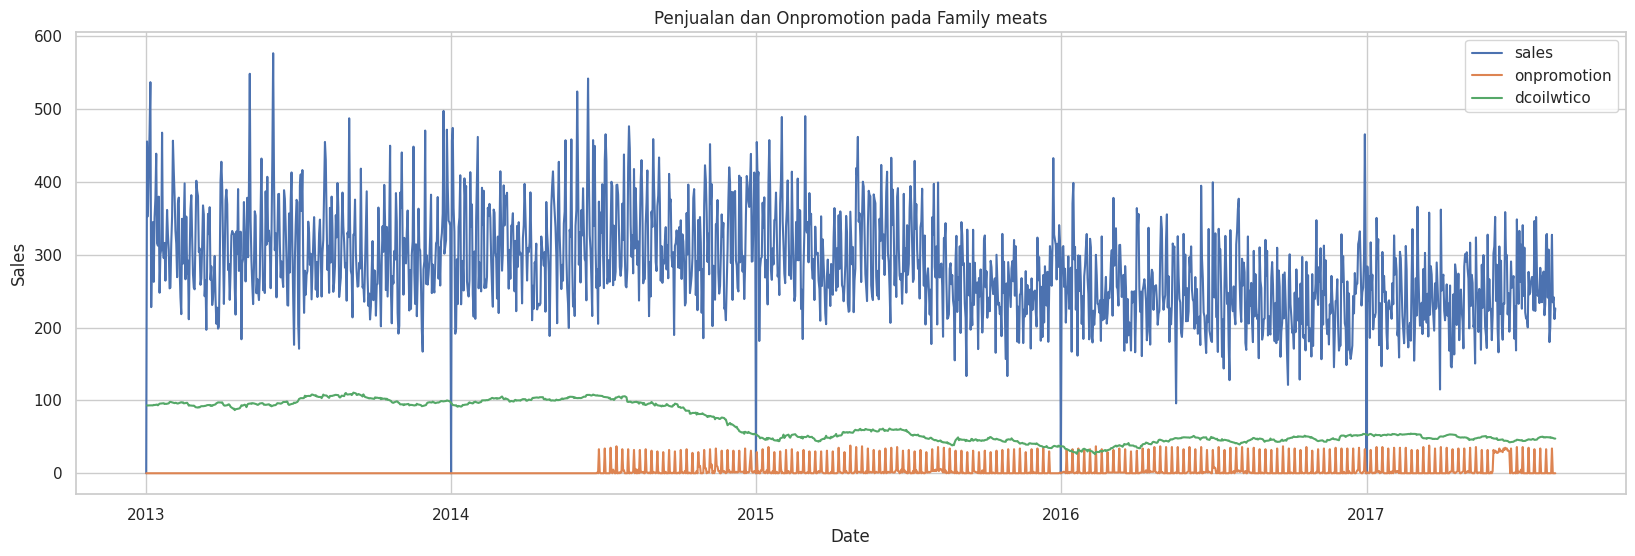

In [16]:
# Melihat pergerakan penjualan, onpromotion dan minyak pada family meats
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=meats, x='date', y='sales', label='sales')
sns.lineplot(data=meats, x='date', y='onpromotion', label='onpromotion')
sns.lineplot(data=meats, x='date', y='dcoilwtico', label='dcoilwtico')
plt.title('Penjualan dan Onpromotion pada Family meats')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [17]:
#Mengubah index data menjadi tanggal 2016 2017
#meats = meats['2016':'2017']

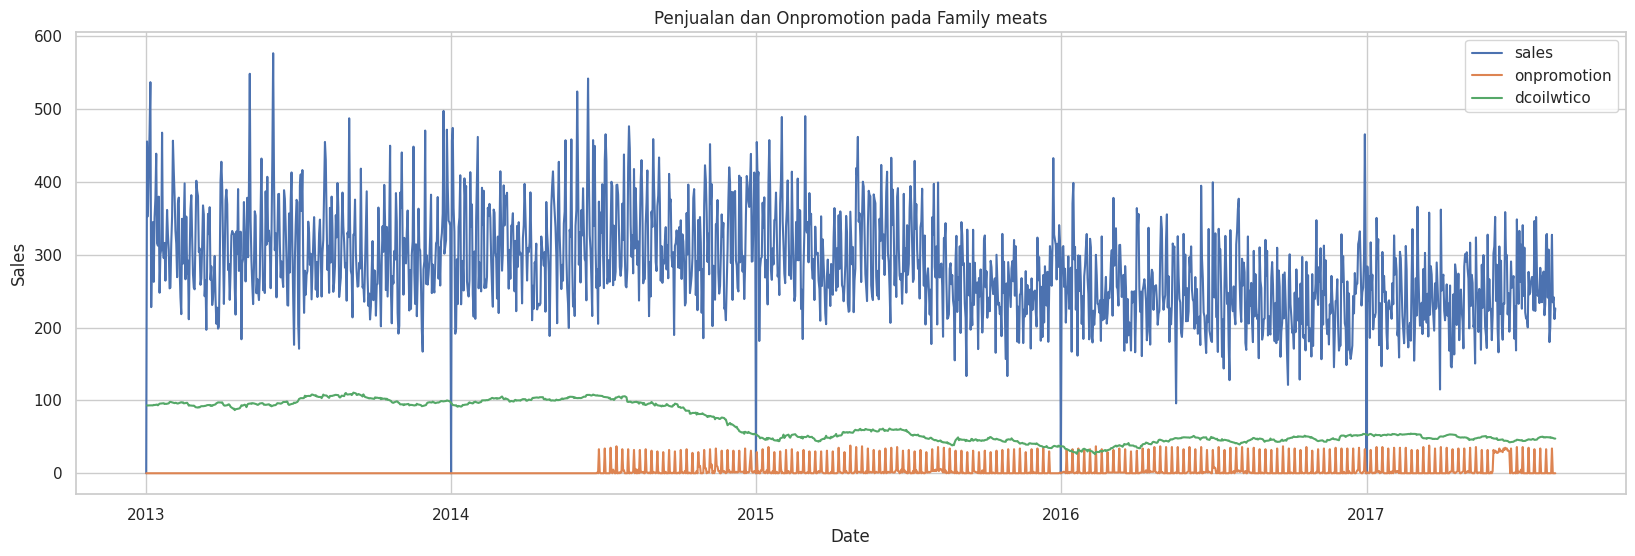

In [18]:
# Melihat kembali penjualan dan onpromotion pada family meats
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=meats, x='date', y='sales', label='sales')
sns.lineplot(data=meats, x='date', y='onpromotion', label='onpromotion')
sns.lineplot(data=meats, x='date', y='dcoilwtico', label='dcoilwtico')
plt.title('Penjualan dan Onpromotion pada Family meats')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<ipython-input-19-99c40dc92ed5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


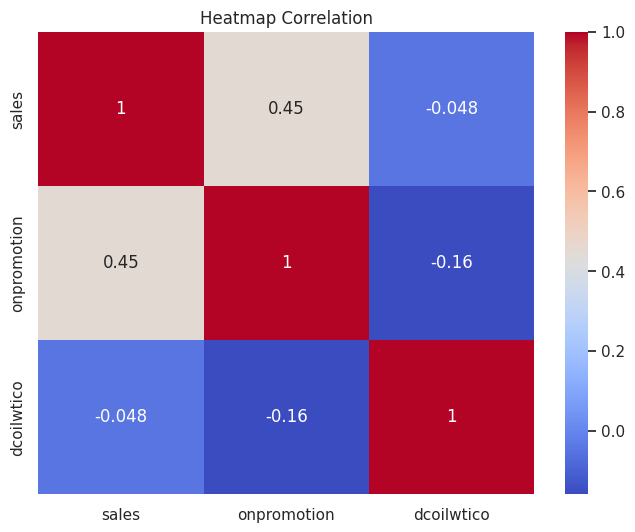

In [19]:
corr_matrix = df_train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap Correlation')
plt.show()

<Axes: xlabel='date'>

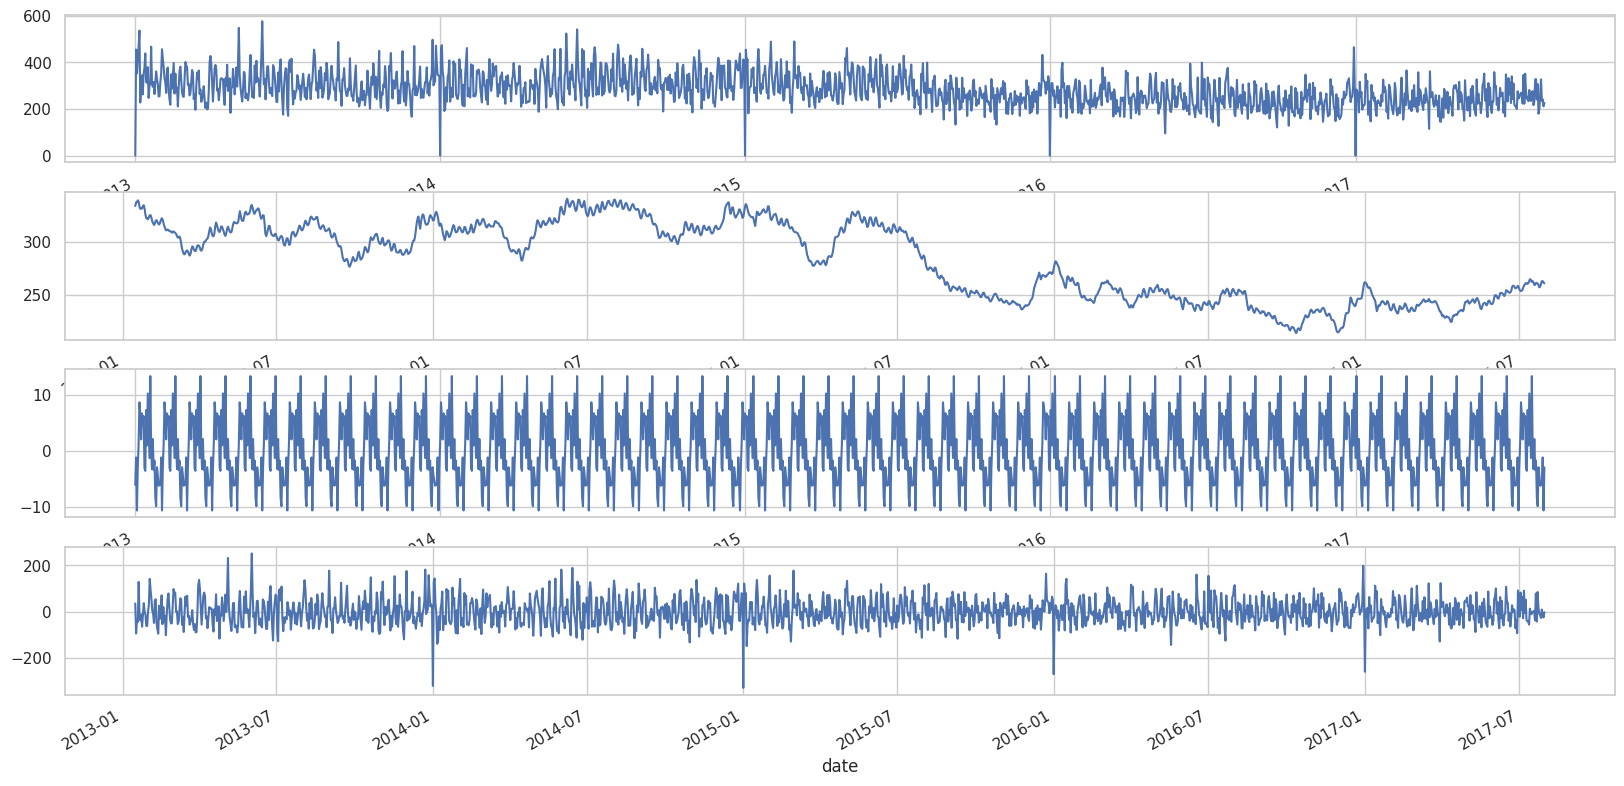

In [20]:
# Decompose data transactions
plot_decompose = seasonal_decompose(meats['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [21]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(meats['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.876441
p-value: 0.048157


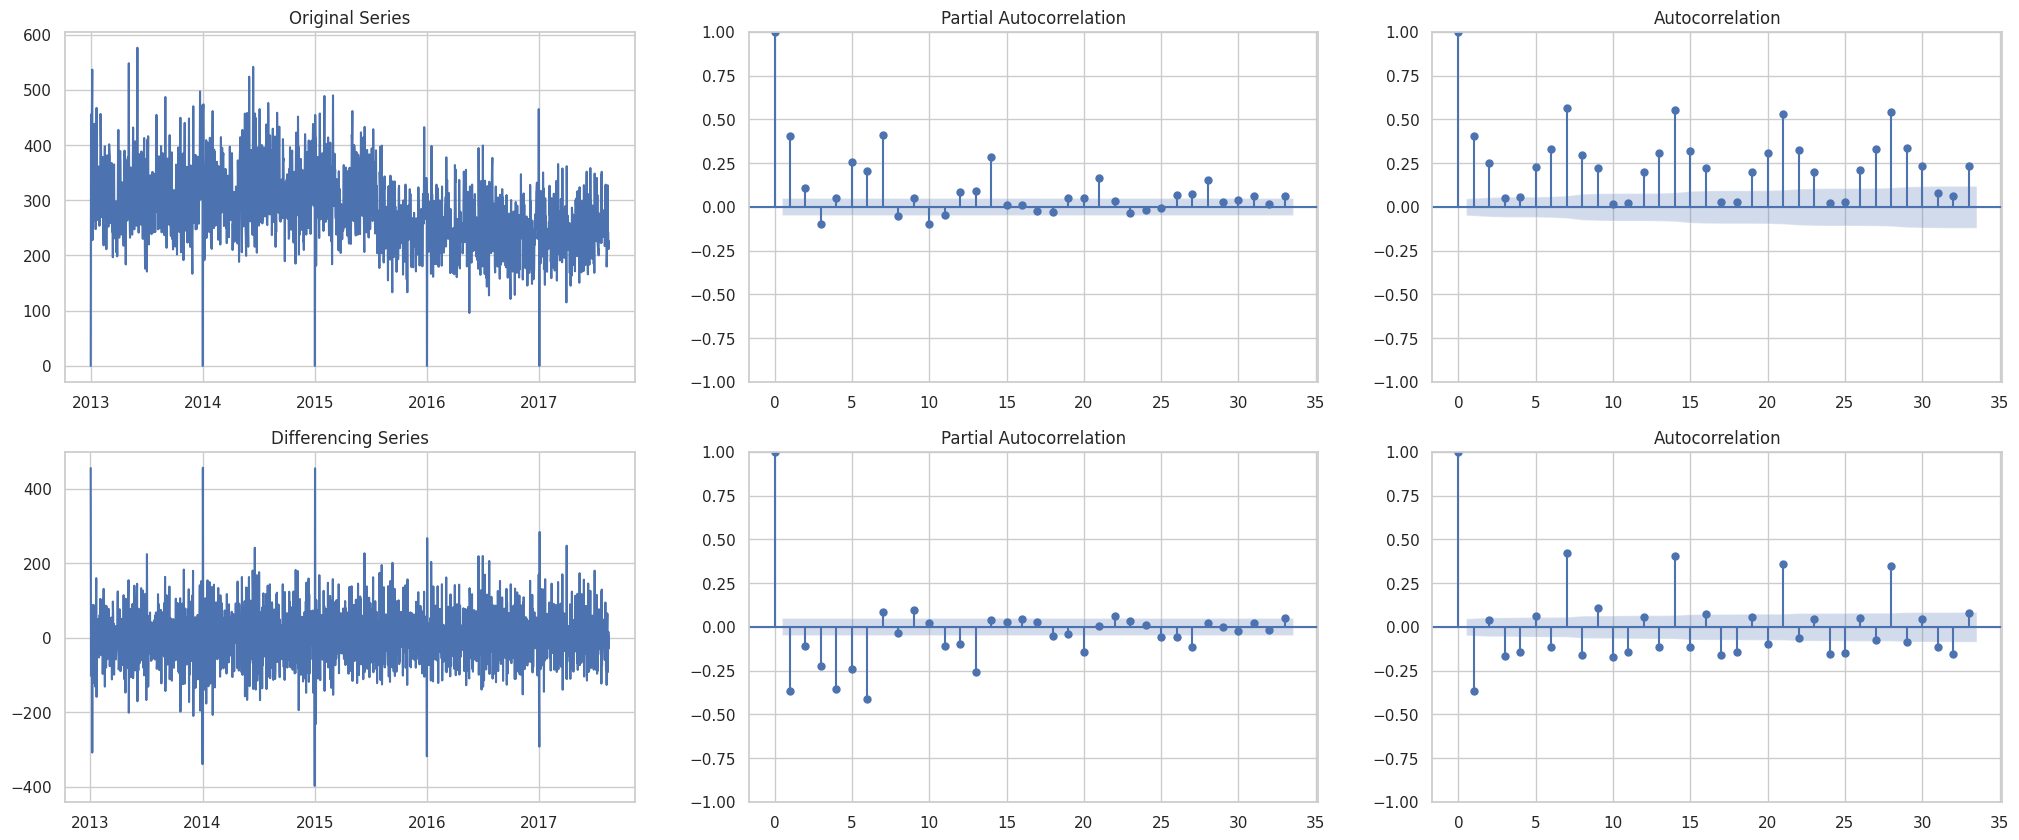

In [22]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(meats['sales'])
ax[0, 1] = plot_pacf(meats['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(meats['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(meats['sales'].diff().dropna())
ax[1, 1] = plot_pacf(meats['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(meats['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

#Feature Engineering

In [23]:
# Imputasi missing value pada dcoilwtico
# Imputasi missing value dengan nilai sehari sebelumnya
meats['dcoilwtico'] = meats['dcoilwtico'].fillna(method='bfill')
meats

<ipython-input-23-d35fa3d1e8a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meats['dcoilwtico'] = meats['dcoilwtico'].fillna(method='bfill')


,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,MEATS,0,0,93
2013-01-02,MEATS,455,0,93
2013-01-03,MEATS,353,0,93
2013-01-04,MEATS,407,0,93
2013-01-05,MEATS,467,0,93
...,...,...,...,...
2017-08-11,MEATS,327,34,49
2017-08-12,MEATS,235,0,48
2017-08-13,MEATS,242,0,48


In [24]:
#Mengambil value row kedua menjadi row pertama untuk menghilangkan outlier
meats.iloc[0, meats.columns.get_loc('sales')] = meats.iloc[1, meats.columns.get_loc('sales')]
meats

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,MEATS,455,0,93
2013-01-02,MEATS,455,0,93
2013-01-03,MEATS,353,0,93
2013-01-04,MEATS,407,0,93
2013-01-05,MEATS,467,0,93
...,...,...,...,...
2017-08-11,MEATS,327,34,49
2017-08-12,MEATS,235,0,48
2017-08-13,MEATS,242,0,48


In [25]:
result = adfuller(meats['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.021800
p-value: 0.032908


In [26]:
meats.drop(['family'], axis=1, inplace=True)
meats

<ipython-input-26-61b13b8d64f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meats.drop(['family'], axis=1, inplace=True)


,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,455,0,93
2013-01-02,455,0,93
2013-01-03,353,0,93
2013-01-04,407,0,93
2013-01-05,467,0,93
...,...,...,...
2017-08-11,327,34,49
2017-08-12,235,0,48
2017-08-13,242,0,48


In [27]:
# Membagi fitur tanggal menjadi tahun, bulan, dan hari
meats = meats.copy()
meats.loc[:, 'year'] = meats.index.year
meats.loc[:, 'month'] = meats.index.month
meats.loc[:, 'day'] = meats.index.day
meats.loc[:, 'dayofweek'] = meats.index.dayofweek
meats

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,
2013-01-01,455,0,93,2013,1,1,1
2013-01-02,455,0,93,2013,1,2,2
2013-01-03,353,0,93,2013,1,3,3
2013-01-04,407,0,93,2013,1,4,4
2013-01-05,467,0,93,2013,1,5,5
...,...,...,...,...,...,...,...
2017-08-11,327,34,49,2017,8,11,4
2017-08-12,235,0,48,2017,8,12,5
2017-08-13,242,0,48,2017,8,13,6


In [28]:
#Membuat lag feature
for i in range(1, 8):
    meats[f'lag_{i}'] = meats['sales'].shift(i)

meats.dropna(inplace=True)
meats.fillna(0, inplace=True)

meats

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,,,,,,,
2013-01-08,314,0,93,2013,1,8,1,228,537,467,407,353,455,455
2013-01-09,345,0,93,2013,1,9,2,314,228,537,467,407,353,455
2013-01-10,263,0,94,2013,1,10,3,345,314,228,537,467,407,353
2013-01-11,351,0,94,2013,1,11,4,263,345,314,228,537,467,407
2013-01-12,377,0,94,2013,1,12,5,351,263,345,314,228,537,467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,327,34,49,2017,8,11,4,265,201,180,307,241,328,327
2017-08-12,235,0,48,2017,8,12,5,327,265,201,180,307,241,328
2017-08-13,242,0,48,2017,8,13,6,235,327,265,201,180,307,241


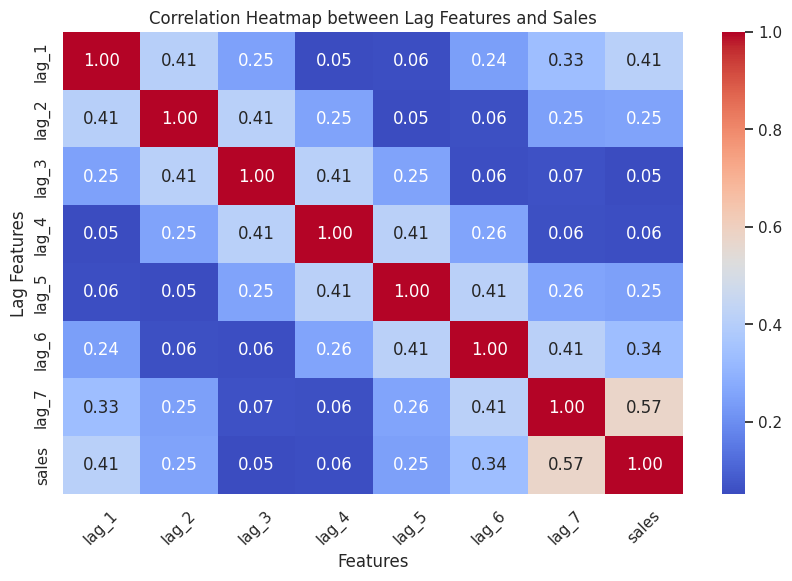

In [29]:
#Melihat korelasi antara lag dengan target
lag_features = [f'lag_{i}' for i in range(1, 8)]
lag_correlation = meats[lag_features + ['sales']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(data=lag_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Lag Features and Sales')
plt.xlabel('Features')
plt.ylabel('Lag Features')
plt.xticks(rotation=45)
plt.show()

##Granger Test untuk korelasi fitur

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causation_matrix(data, variables, maxlag, test='ssr_chi2test'):
    """Computes Granger Causality matrix
    Returns: DataFrame

    test : str, {'ssr_chi2test', 'ssr_ftest', 'lrtest'}
        Type of Granger causality test
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for cause in df.columns:
        for effect in df.index:
            gc_result = grangercausalitytests(data[[cause, effect]], maxlag=maxlag, verbose=False)
            p_values = [round(gc_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[effect, cause] = min_p_value
    return df

In [31]:
import warnings
warnings.filterwarnings("ignore", message="verbose is deprecated")

#Melihat korelasi antar feature
variables = ['sales', 'onpromotion', 'dcoilwtico']
maxlag = 7

result = granger_causation_matrix(meats, variables, maxlag)

# Output Formatting
print("Granger Causality Results:\n")
result

Granger Causality Results:



,sales,onpromotion,dcoilwtico
sales,1,0,0
onpromotion,0,1,0
dcoilwtico,0,0,1


In [32]:
# Menambahkan rolling window mean pada sales sepanjang 7 hari
meats['sales_mean_7'] = meats['sales'].rolling(window=7).mean()
# Menambahkan rolling window mean pada sales sepanjang 30 hari
meats['sales_mean_30'] = meats['sales'].rolling(window=30).mean()

meats.dropna(inplace=True)
meats.fillna(0, inplace=True)

meats

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,sales_mean_7,sales_mean_30
date,,,,,,,,,,,,,,,,
2013-02-06,315,0,96,2013,2,6,2,333,380,415,456,352,316,255,367,333
2013-02-07,269,0,96,2013,2,7,3,315,333,380,415,456,352,316,360,331
2013-02-08,371,0,96,2013,2,8,4,269,315,333,380,415,456,352,363,332
2013-02-09,378,0,97,2013,2,9,5,371,269,315,333,380,415,456,352,336
2013-02-10,281,0,97,2013,2,10,6,378,371,269,315,333,380,415,332,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,327,34,49,2017,8,11,4,265,201,180,307,241,328,327,264,262
2017-08-12,235,0,48,2017,8,12,5,327,265,201,180,307,241,328,251,263
2017-08-13,242,0,48,2017,8,13,6,235,327,265,201,180,307,241,251,262


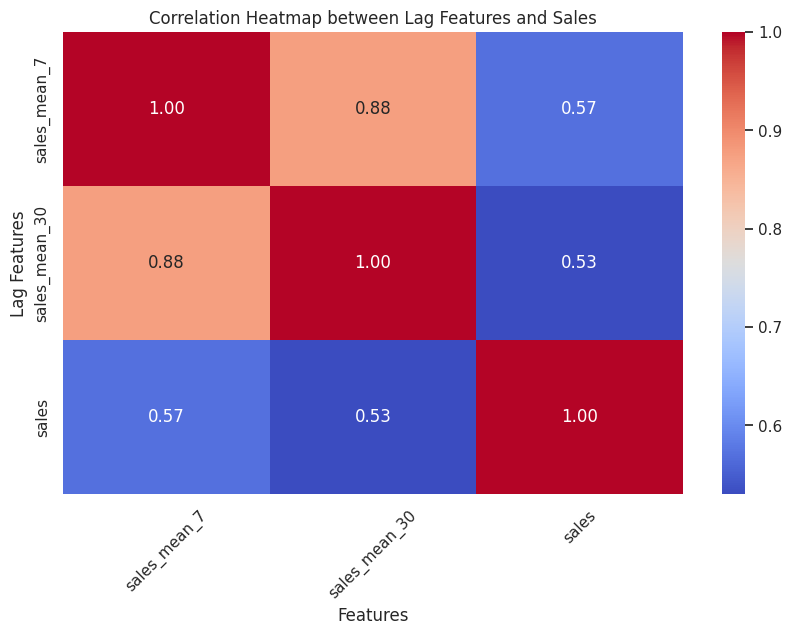

In [33]:
#Melihat korelasi antara lag dengan target
mean = ['sales_mean_7', 'sales_mean_30']
sale_mean = meats[mean + ['sales']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(data=sale_mean, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Lag Features and Sales')
plt.xlabel('Features')
plt.ylabel('Lag Features')
plt.xticks(rotation=45)
plt.show()

In [34]:
#Delete feature tidak terpakai
meats.drop(columns=[f'lag_{i}' for i in range(1, 7)] + ['sales_mean_30'], axis=1, inplace=True)
meats

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,lag_7,sales_mean_7
date,,,,,,,,,
2013-02-06,315,0,96,2013,2,6,2,255,367
2013-02-07,269,0,96,2013,2,7,3,316,360
2013-02-08,371,0,96,2013,2,8,4,352,363
2013-02-09,378,0,97,2013,2,9,5,456,352
2013-02-10,281,0,97,2013,2,10,6,415,332
...,...,...,...,...,...,...,...,...,...
2017-08-11,327,34,49,2017,8,11,4,327,264
2017-08-12,235,0,48,2017,8,12,5,328,251
2017-08-13,242,0,48,2017,8,13,6,241,251


In [35]:
# Split data menjadi data training dan data testing
train = meats[:-30]
test = meats[-30:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1618, 9)
Test shape: (30, 9)


#Modeling

##Model SARIMAX

In [54]:
# Seasonal ARIMA X (SARIMAX)
model_sarimax = ARIMA(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), exog=train[['onpromotion','sales_mean_7','lag_7']])
model_sarimax_fit = model_sarimax.fit()
print(model_sarimax_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1618
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8376.577
Date:                         Fri, 15 Mar 2024   AIC                          16769.153
Time:                                 09:34:40   BIC                          16812.225
Sample:                                      0   HQIC                         16785.142
                                        - 1618                                         
Covariance Type:                           opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
onpromotion      1.7490      0.208      8.424      0.000       1.342       2.156
sales_mean_7     0.9666      0.048     19.952      0.

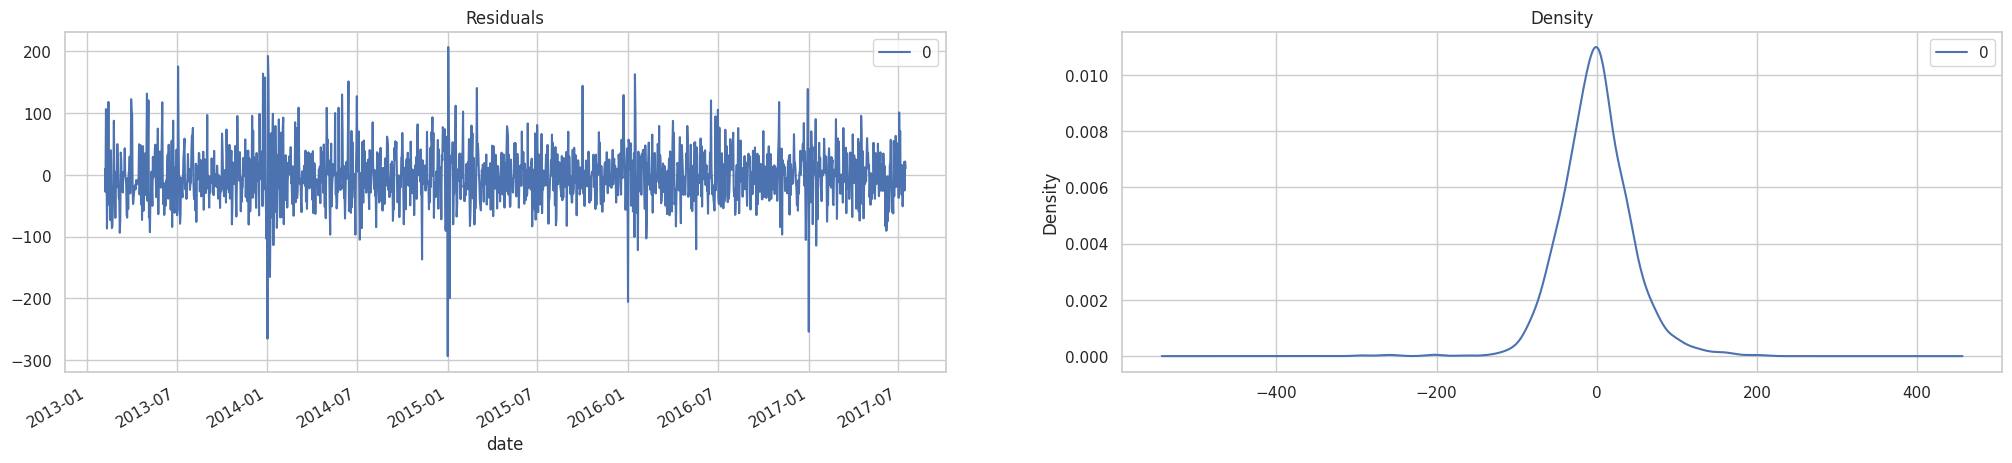

In [37]:
# Plot residual errors
residuals = pd.DataFrame(model_sarimax_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


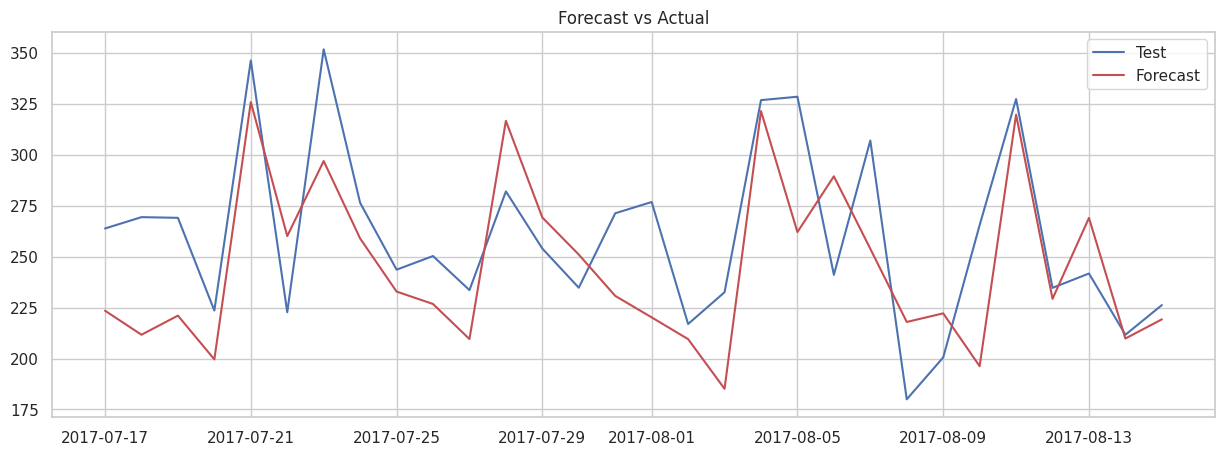

In [38]:
# Prediction
exog_forecast = test[['onpromotion','sales_mean_7','lag_7']]  # Ambil nilai eksogen dari data uji
forecast = model_sarimax_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_forecast, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [39]:
# check forecast row
forecastSARIMAX = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMAX

,test,forecast
date,,
2017-07-17,264,223
2017-07-18,269,212
2017-07-19,269,221
2017-07-20,224,200
2017-07-21,346,326
2017-07-22,223,260
2017-07-23,352,297
2017-07-24,276,259
2017-07-25,244,233


##Model LSTM

In [40]:
# Split data
# Scalling

dcoilwtico_scaler = MinMaxScaler()
sales_scaler = MinMaxScaler()
x = meats[['lag_7', 'sales_mean_7', 'onpromotion']].copy()
y = meats['sales'].copy()

y = sales_scaler.fit_transform(y.values.reshape(-1, 1))
x['lag_7'] = sales_scaler.transform(x['lag_7'].values.reshape(-1, 1))
x['sales_mean_7'] = sales_scaler.transform(x['sales_mean_7'].values.reshape(-1, 1))
x['onpromotion'] = sales_scaler.transform(x['onpromotion'].values.reshape(-1, 1))

In [41]:
def load_data(X, seq_len, test_size=30):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)
    train_data = data[:-test_size]  # Exclude last 'test_size' data points for test set

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    x_test = data[-test_size:, :-1]
    y_test = data[-test_size:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 7
x['sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window,test_size=30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1610, 7, 4) (1610,) (30, 7, 4) (30,)


In [42]:
#LSTM architecture
modelLSTM = Sequential()

# First LSTM layer with Dropout regularization
modelLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(window, 4)))
modelLSTM.add(Dropout(0.2))
# Second LSTM layer
modelLSTM.add(LSTM(units=25, return_sequences=False))

modelLSTM.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

# Compiling the RNN
modelLSTM.compile(optimizer='adam',loss='mse')
# Fitting to the training set
start = time.time()
history1=modelLSTM.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100
44/44 [==============================] - 5s 31ms/step - loss: 0.0893 - val_loss: 0.0077
Epoch 2/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0133 - val_loss: 0.0083
Epoch 3/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0087
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0118 - val_loss: 0.0074
Epoch 6/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 7/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0117 - val_loss: 0.0079
Epoch 8/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 9/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0115 - val_loss: 0.0072
Epoch 10/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0077
Epoc

In [43]:
trainPredict = modelLSTM.predict(X_train)
testPredict = modelLSTM.predict(X_test)

trainPredict = sales_scaler.inverse_transform(trainPredict)
trainY = sales_scaler.inverse_transform([y_train])
testPredict = sales_scaler.inverse_transform(testPredict)
testY = sales_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 23ms/step
(30, 1)
(30, 1)


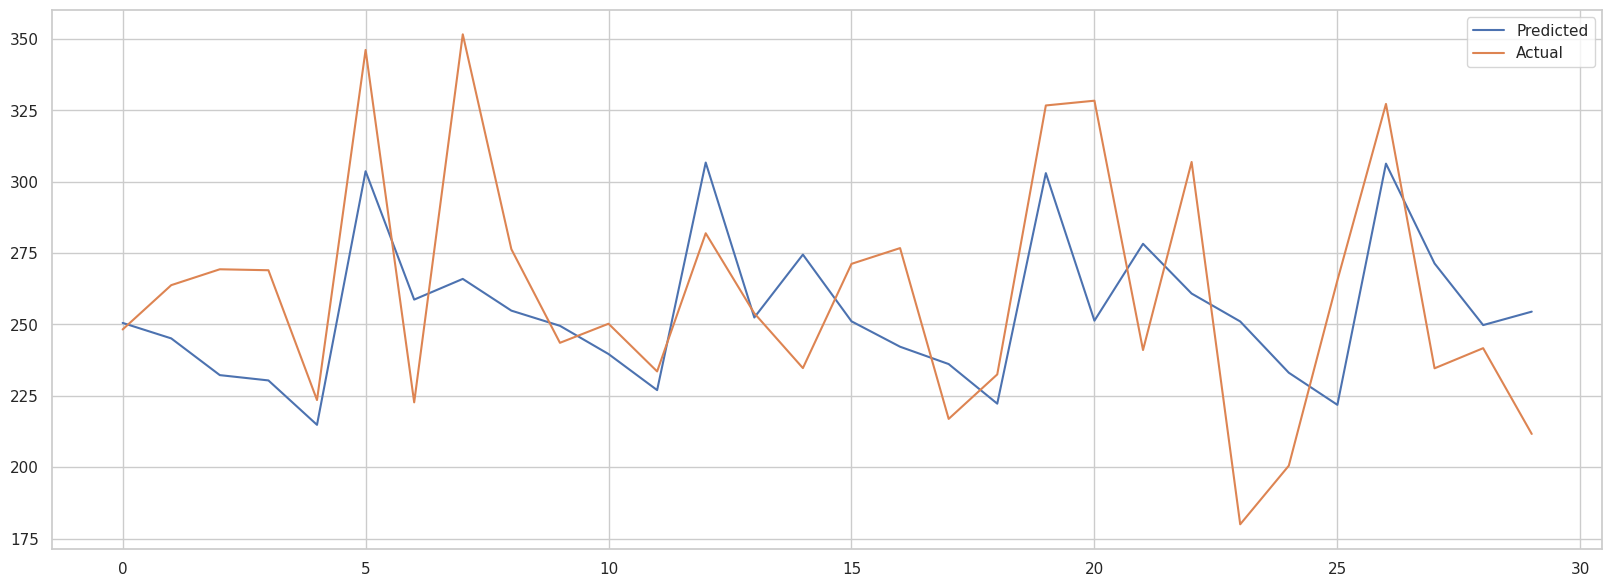

In [44]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [45]:
plot_predicted = plot_predicted.reshape(30,)

forecastLSTM = pd.DataFrame({'test': test['sales'], 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
date,,
2017-07-17,264,251
2017-07-18,269,245
2017-07-19,269,232
2017-07-20,224,230
2017-07-21,346,215
2017-07-22,223,304
2017-07-23,352,259
2017-07-24,276,266
2017-07-25,244,255


##Facebook Prophet Model

In [46]:
trainP = train.copy()
trainP = trainP.reset_index()
trainP = trainP.rename(columns={'date': 'ds', 'sales': 'y'})

testP = test.copy()
testP = testP.reset_index()
testP = testP.rename(columns={'date': 'ds', 'sales': 'y'})

In [47]:
trainP.head()

,ds,y,onpromotion,dcoilwtico,year,month,day,dayofweek,lag_7,sales_mean_7
0,2013-02-06,315,0,96,2013,2,6,2,255,367
1,2013-02-07,269,0,96,2013,2,7,3,316,360
2,2013-02-08,371,0,96,2013,2,8,4,352,363
3,2013-02-09,378,0,97,2013,2,9,5,456,352
4,2013-02-10,281,0,97,2013,2,10,6,415,332


In [48]:
testP.head()

,ds,y,onpromotion,dcoilwtico,year,month,day,dayofweek,lag_7,sales_mean_7
0,2017-07-17,264,0,46,2017,7,17,0,221,237
1,2017-07-18,269,0,46,2017,7,18,1,212,245
2,2017-07-19,269,0,47,2017,7,19,2,212,253
3,2017-07-20,224,0,47,2017,7,20,3,200,257
4,2017-07-21,346,33,46,2017,7,21,4,276,267


In [49]:
model = Prophet()
model.fit(trainP)

future_dates = model.make_future_dataframe(periods=len(testP))
test_forecast = model.predict(future_dates)
future_dates

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvypp6hlu/nsm821ee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvypp6hlu/d45gew3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17141', 'data', 'file=/tmp/tmpvypp6hlu/nsm821ee.json', 'init=/tmp/tmpvypp6hlu/d45gew3h.json', 'output', 'file=/tmp/tmpvypp6hlu/prophet_modelzfyl0n76/prophet_model-20240315092812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2013-02-06
1,2013-02-07
2,2013-02-08
3,2013-02-09
4,2013-02-10
...,...
1643,2017-08-11
1644,2017-08-12
1645,2017-08-13
1646,2017-08-14


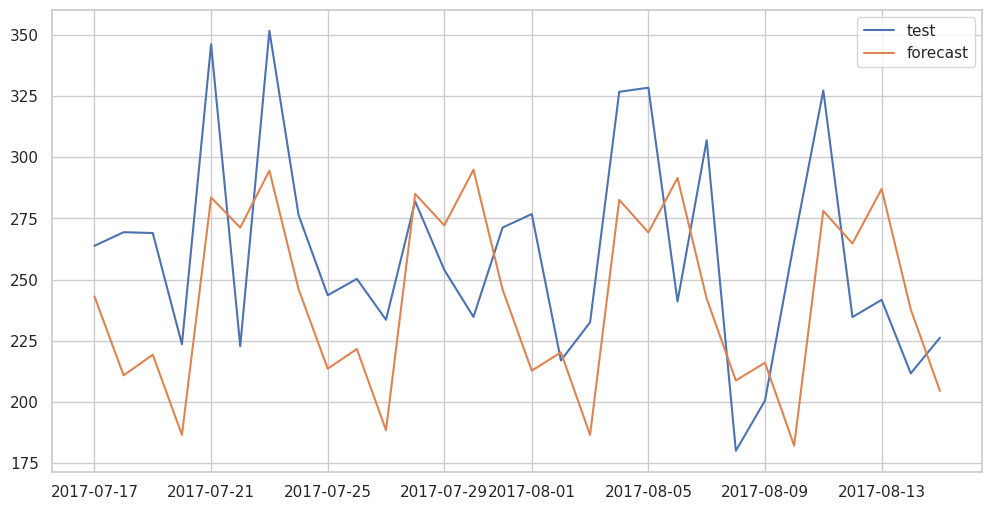

In [50]:
# Combine actuals and forecasts for plotting
results = testP[['ds', 'y']].merge(test_forecast[['ds', 'yhat']], how='left', on='ds')
results.rename(columns={'y': 'test', 'yhat': 'forecast'}, inplace=True)

# Generate plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['test'], label='test')
plt.plot(results['ds'], results['forecast'], label='forecast')
plt.legend()
plt.show()

In [51]:
results.set_index('ds')

,test,forecast
ds,,
2017-07-17,264,243
2017-07-18,269,211
2017-07-19,269,219
2017-07-20,224,186
2017-07-21,346,284
2017-07-22,223,271
2017-07-23,352,294
2017-07-24,276,246
2017-07-25,244,214


# Evaluation

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#MAPE
def mapeEv(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model = [forecastSARIMAX, forecastLSTM, results]
model_name = ['SARIMAX', 'LSTM', 'FBProphet']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    rmse = np.sqrt(mse)
    mape = mapeEv(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, rmse, mape])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'RMSE', 'MAPE'], index=model_name)
metrics

,MAE,MSE,RMSE,MAPE
SARIMAX,31,"1,340",37,12
LSTM,40,"2,812",53,15
FBProphet,40,"1,983",45,15
